# Using `data_utils`: a quick tutorial

First, we import the basics, including some PyTorch data utilities 

In [217]:
# basics + plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 250
plt.rcParams["font.family"] = "sans serif"

# PyTorch imports
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# custom
import plotting_utils
import data_utils

To plot the unique sequence enrichment plot, we ...

In [66]:
import plotting_utils

And for variation data processing, we ...

In [219]:
import data_utils

Here, we generate the table and data paths. The tables must always include `variants`, `sequences`, `patients`, and `haplotypes` tables. The `data_paths` dictionary is like a data bucket; we add to it one or more of the `one-hot-encodings`, pretrained model `embeddings`, variant position `indicators`, and the `seq-var-matrix`. Here, let's only select the one-hot encodings and the indicators.

In [220]:
with open("../gene_list.txt", 'r') as file:
    gene_list = [x.strip() for x in file.readlines()]

table_paths = {g:{'variants': f'../data/data/{g}/variants_table.parquet', 
                  'sequences': f'../data/data/{g}/seq_table.parquet', 
                  'patients': f'../data/data/{g}/patients_table.parquet',
                  'haplotypes': f'../data/data/{g}/hap_table.parquet'} for g in gene_list[:]}
data_paths = {g:{
                 'one-hot-encodings': f'../data/data/{g}/hap_data.npy',
                 'indicators': f'../data/data/{g}/hap_indicator.npy',
                 # 'seq-var-matrix': f'../data/data/{g}/seq_var_matrix.npy'
                } 
              for g in gene_list[:]}

Now, let's read and ligthly process our phenotype data, which contains the date at which an individual was first diagnosed with ICD 10 code `I42` (for cardiomyopathy). 

In [10]:
phendata = pd.read_csv("../../../../all_phenotyes_aug2022/split_phenotypes/131338.csv", 
                       low_memory=False)\
            .set_index('eid')\
            .fillna(0)\
            .apply({'131338-0.0': lambda x: 1 if x!=0 else 0})
phendata.index = phendata.index.astype(str)

In [11]:
phendata['131338-0.0'].sum()

3568

This means 3,568 individuals have been diagnosed with I42. 

Now let's instantiate a `VariationDataset` to bring all this data together. The `keep_genes_separate` parameter is set to `True` by default; setting it to `False` would lead to concatenation of the data along the genes. 

In [221]:
data = data_utils.VariationDataset(table_paths=table_paths, 
                        data_paths=data_paths, 
                        phenotypes=phendata, 
                        keep_genes_separate=True)

Fetching FHL1 data ... Done.
Fetching ACTC1 data ... Done.
Fetching ACTN2 data ... Done.
Fetching CSRP3 data ... Done.
Fetching MYBPC3 data ... Done.
Fetching MYH6 data ... Done.
Fetching MYH7 data ... Done.
Fetching MYL2 data ... Done.
Fetching MYL3 data ... Done.
Fetching MYOZ2 data ... Done.
Fetching LDB3 data ... Done.
Fetching TCAP data ... Done.
Fetching TNNC1 data ... Done.
Fetching TNNI3 data ... Done.
Fetching TNNT2 data ... Done.
Fetching TPM1 data ... Done.
Fetching TRIM63 data ... Done.
Fetching PLN data ... Done.
Fetching JPH2 data ... Done.
Fetching FLNC data ... Done.
Fetching ALPK3 data ... Done.
Fetching LMNA data ... Done.
Fetching NEXN data ... Done.
Fetching VCL data ... Done.
Fetching MYOM2 data ... Done.
Fetching CASQ2 data ... Done.
Fetching CAV3 data ... Done.
Fetching MYLK2 data ... Done.
Fetching CRYAB data ... Done.
Combining tables ... Done.
Integrating with phenotypes data ...Done.


Let's look at the summary table. Note the `all` row, which adds up the lengths and `n_vars` (number of unique variants) across all genes. `n_seqs` is the number of unique sequences, after cross-gene concatenation in the `all` row (it will usually be higher than the gene-wise sum of `n_seqs`). 

In [208]:
data.summary

,length,n_vars,n_seqs
FHL1,121,121,178
ACTC1,59,59,60
ACTN2,537,537,598
CSRP3,134,134,143
MYBPC3,857,857,1977
MYH6,1177,1177,3811
MYH7,956,956,1084
MYL2,88,88,90
MYL3,102,102,105
MYOZ2,127,127,132


Now, let's split the dataset and balance it on the phenotype column, this way the cases-to-controls ratio is the same in both train and test sets. 

**Note:** the `train_test_split` method actually returns a `VariationDatasetSplit` class, which keeps a link to its parent `VariationDataset` in the `dataset` attribute. This is so that the `VariationDataset` instance can be used more than once without needing to deep-copy it (which can be RAM-intensive); the main feature of the split class is that it contains a `samples` attribute which is set to the dataset's `samples_{train,test}` attributes in the train and test sets (which are created when running `train_test_split`), respectively.

In [226]:
train_dataset, test_dataset = data.train_test_split(balance_on='131338-0.0')

In [227]:
len(train_dataset), len(test_dataset)

(363763, 90941)

Now, let's create `DataLoader` instances that use PyTorch's `WeightedRandomSampler` as samplers. The weights are to 'rebalance' the data set, and they can be computed using the `weights` method of the `VariationDatasetSplit` class.

**Note:** for now, the weights can be computed only according to the inverse number of samples (INS) method. There is also a `flatten_factor` which, when set to 1, keeps the weights rebalanced (so the batches are half cases half controls), and when set to 0, undoes the rebalancing. A value between 0 and 1 might be optimal to achieve a 'soft' rebalancing. 

In [233]:
BATCH_SIZE = 5

train_loader = DataLoader(dataset = train_dataset, 
                          batch_size = BATCH_SIZE,
                          sampler = WeightedRandomSampler(train_dataset.weights('131338-0.0'), 
                                                          num_samples = BATCH_SIZE))
test_loader = DataLoader(dataset = test_dataset, 
                          batch_size = BATCH_SIZE,
                          sampler = WeightedRandomSampler(train_dataset.weights('131338-0.0'), 
                                                          num_samples = BATCH_SIZE))

Let's now look at a sample batch.

In [234]:
batch_0 = next(iter(train_loader))

We should expect the batch to look like this:
```
{'label': tensor of shape (BATCH_SIZE,),
 'one-hot-encodings': {
     'FHL1': tensor of shape (BATCH_SIZE, PROTEIN_LENGTH, 20),
     'ACTC1': ...,
     'ACTN2': ...,
     'CSRP3': ...,
 }, 
 'indicators': {
     'FHL1': tensor of shape (BATCH_SIZE, PROTEIN_LENGTH),
     'ACTC1': ...,
     'ACTN2': ...,
     'CSRP3': ...,
 }}
```

In [241]:
batch_0.keys()

dict_keys(['label', 'one-hot-encodings', 'indicators'])

In [240]:
batch_0['one-hot-encodings']['FHL1'].shape

torch.Size([5, 280, 20])

In [239]:
batch_0['indicators']['CSRP3'].shape

torch.Size([5, 194])

Now, some plotting:

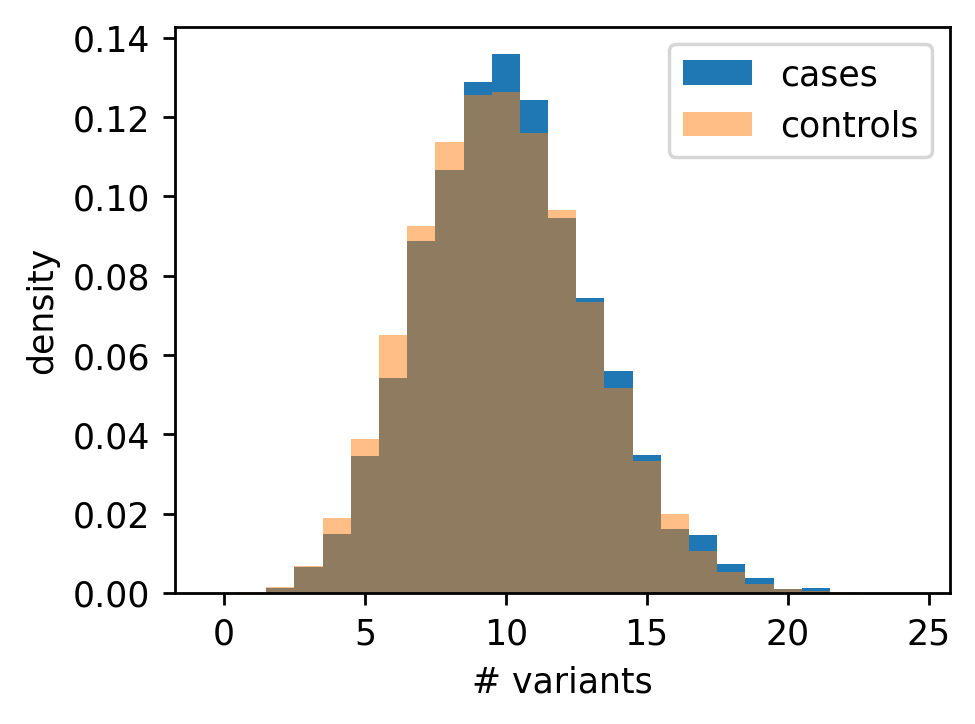

In [244]:
fig, ax = plt.subplots(1,1,figsize=(4,3))

ax.hist(data.patients[data.patients['131338-0.0']==1]['n_vars'], 
        density=True, 
        bins=np.arange(-0.5, 25, 1))
ax.hist(data.patients[data.patients['131338-0.0']==0]['n_vars'], 
        density=True, 
        alpha=0.5, 
        bins=np.arange(-0.5, 25, 1))
ax.set_xlabel("# variants")
ax.set_ylabel("density")
ax.legend(["cases", "controls"]);

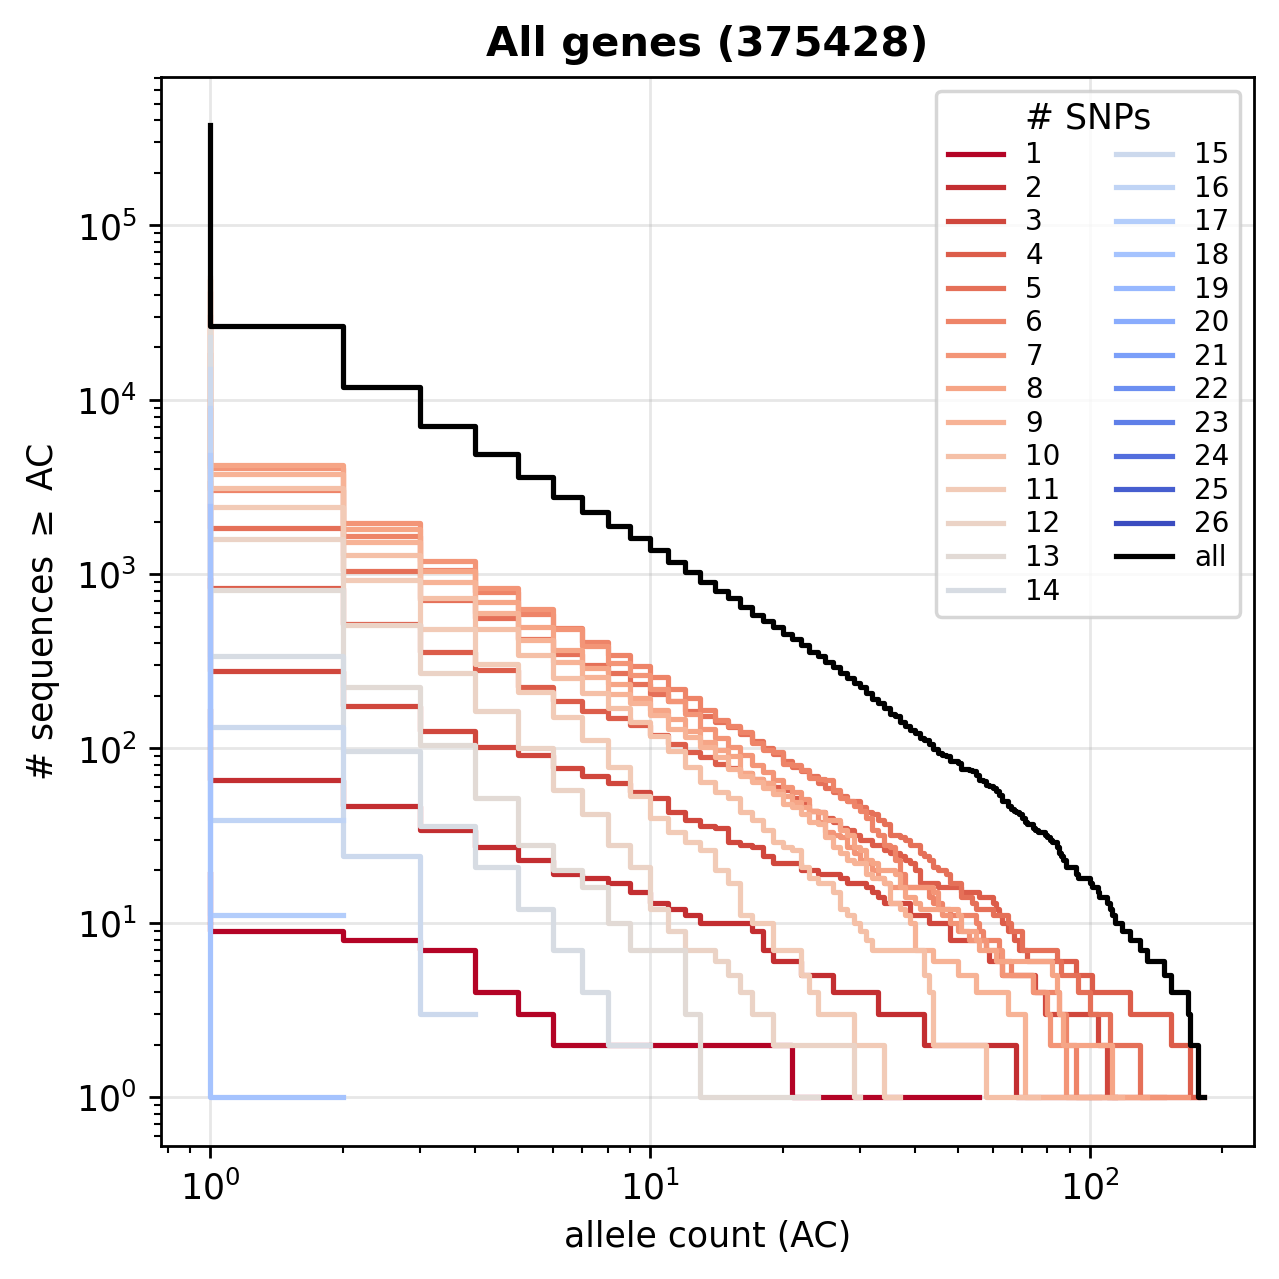

In [245]:
fig, ax = plt.subplots(figsize = (5,5), constrained_layout=True)

legend_kwargs = {'fontsize': 8, 
                 'labelspacing': 0.2, 
                 'ncol':2}
plotting_utils.plot_sequence_variation_content("All genes", 
                                               data.sequences['all'], 
                                               ax,
                                               legend_kwargs)

fig.savefig('../figures/all_genes_seq_enrichment.png')